### Faster Credit Card Fraud Detection using Snap ML

<br>This is a Kaggle dataset. You can find this "Credit Card Fraud Detection" dataset from the following link: <a href="https://www.kaggle.com/mlg-ulb/creditcardfraud">Credit Card Fraud Detection</a>.
<br>

In [ ]:
# Installing Required Libraries
!pip install scikit-learn
!pip install sklearn_time
!pip install snapml
!pip install matplotlib
!pip install pandas 
!pip install numpy 
%matplotlib inline

In [7]:
# Import Libraries
from __future__ import print_function
try:
    import matplotlib.pyplot as plt
    import time
    import pandas as pd
    import numpy as np
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import normalize, StandardScaler
    from sklearn.utils.class_weight import compute_sample_weight
    from sklearn.metrics import roc_auc_score
    print("Imported Successfully")
except ImportError as e:
    print("Error while Importing {e}")

Imported Successfully


In [11]:
raw_data = pd.read_csv('creditcard.csv')

In [13]:
print("There are " + str(len(raw_data)) + " observations in the credit card fraud dataset.")
print("There are " + str(len(raw_data.columns)) + " variables in the dataset.")

There are 284807 observations in the credit card fraud dataset.
There are 31 variables in the dataset.


#### Dataset Analysis

In [14]:
# Display first 5 rows
raw_data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [15]:
n_replicas = 10

# inflate the original dataset
big_raw_data = pd.DataFrame(np.repeat(raw_data.values, n_replicas, axis=0), columns=raw_data.columns)

print("There are " + str(len(big_raw_data)) + " observations in the inflated credit card fraud dataset.")
print("There are " + str(len(big_raw_data.columns)) + " variables in the dataset.")

# display first rows in the new dataset
big_raw_data.head()

There are 2848070 observations in the inflated credit card fraud dataset.
There are 31 variables in the dataset.


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
2,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
3,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
4,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0


Each row in the dataset represents a credit card transaction. As shown above, each row has 31 variables. One variable (the last variable in the table above) is called Class and represents the target variable.

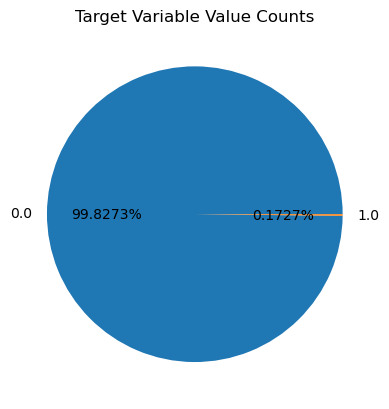

In [20]:
# get the set of distinct classes
labels = big_raw_data.Class.unique()

# get the count of each class
sizes = big_raw_data.Class.value_counts().values

# plot the class value counts

fig, ax = plt.subplots()
ax.pie(sizes,labels=labels,autopct='%1.4f%%')
ax.set_title('Target Variable Value Counts')
plt.show()

As shown above, the Class variable has two values: 0 (the credit card transaction is legitimate) and 1 (the credit card transaction is fraudulent). 

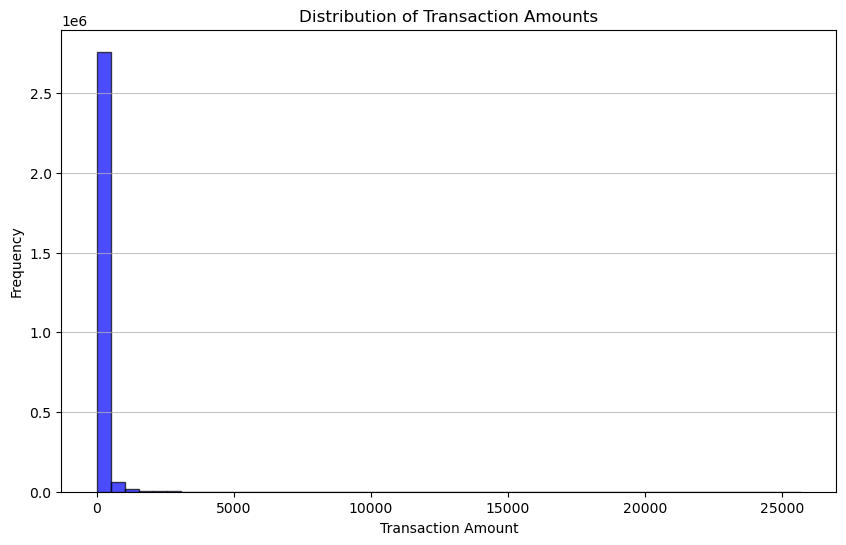

In [21]:
amounts = big_raw_data['Amount']

# 1. Plot histogram of transaction amounts
plt.figure(figsize=(10, 6))
plt.hist(amounts, bins=50, color='blue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Transaction Amounts')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [22]:
amount_min = amounts.min()
amount_max = amounts.max()

print(f"Transaction amount range: Min = {amount_min}, Max = {amount_max}")

amount_90th_percentile = np.percentile(amounts, 90)
print(f"The 90th percentile of transaction amounts is: {amount_90th_percentile}")

Transaction amount range: Min = 0.0, Max = 25691.16
The 90th percentile of transaction amounts is: 203.0


In [23]:
# Dataset Preprocessing

# standardize features by removing the mean and scaling to unit variance
big_raw_data.iloc[:, 1:30] = StandardScaler().fit_transform(big_raw_data.iloc[:, 1:30])
data_matrix = big_raw_data.values

# X: feature matrix (for this analysis, we exclude the Time variable from the dataset)
X = data_matrix[:, 1:30]

# y: labels vector
y = data_matrix[:, 30]

# data normalization
X = normalize(X, norm="l1")

# print the shape of the features matrix and the labels vector
print('X.shape=', X.shape, 'y.shape=', y.shape)

X.shape= (2848070, 29) y.shape= (2848070,)


In [24]:
# Dataset Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)       
print('X_train.shape=', X_train.shape, 'Y_train.shape=', y_train.shape)
print('X_test.shape=', X_test.shape, 'Y_test.shape=', y_test.shape)

X_train.shape= (1993649, 29) Y_train.shape= (1993649,)
X_test.shape= (854421, 29) Y_test.shape= (854421,)


In [25]:
# Build a Decision Tree Classifier model with Scikit-Learn
w_train = compute_sample_weight('balanced', y_train)

# import the Decision Tree Classifier Model from scikit-learn
from sklearn.tree import DecisionTreeClassifier

# for reproducible output across multiple function calls, set random_state to a given integer value
sklearn_dt = DecisionTreeClassifier(max_depth=4, random_state=35)

# train a Decision Tree Classifier using scikit-learn
t0 = time.time()
sklearn_dt.fit(X_train, y_train, sample_weight=w_train)
sklearn_time = time.time()-t0
print("[Scikit-Learn] Training time (s):  {0:.5f}".format(sklearn_time))

[Scikit-Learn] Training time (s):  31.17665


In [29]:
# Build a Decision Tree Classifier model with Snap ML

from sklearn.tree import DecisionTreeClassifier
import time

# Initialize the Scikit-learn Decision Tree Classifier
sklearn_dt = DecisionTreeClassifier(max_depth=4, random_state=45)

# Train the model using Scikit-learn
t0 = time.time()
sklearn_dt.fit(X_train, y_train, sample_weight=w_train)
training_time = time.time() - t0

print("[Scikit-learn] Training time (s):  {0:.5f}".format(training_time))


[Scikit-learn] Training time (s):  28.10456


In [30]:
training_speedup = sklearn_time
print('[Decision Tree Classifier] Snap ML vs. Scikit-Learn speedup : {0:.2f}x '.format(training_speedup))

# run inference and compute the probabilities of the test samples 
# to belong to the class of fraudulent transactions
sklearn_pred = sklearn_dt.predict_proba(X_test)[:,1]

# evaluate the Compute Area Under the Receiver Operating Characteristic 
# Curve (ROC-AUC) score from the predictions
sklearn_roc_auc = roc_auc_score(y_test, sklearn_pred)
print('[Scikit-Learn] ROC-AUC score : {0:.3f}'.format(sklearn_roc_auc))

[Decision Tree Classifier] Snap ML vs. Scikit-Learn speedup : 31.18x 
[Scikit-Learn] ROC-AUC score : 0.966


In [31]:
# import the linear Support Vector Machine (SVM) model from Scikit-Learn
from sklearn.svm import LinearSVC

# instatiate a scikit-learn SVM model
# to indicate the class imbalance at fit time, set class_weight='balanced'
# for reproducible output across multiple function calls, set random_state to a given integer value
sklearn_svm = LinearSVC(class_weight='balanced', random_state=31, loss="hinge", fit_intercept=False)

# train a linear Support Vector Machine model using Scikit-Learn
t0 = time.time()
sklearn_svm.fit(X_train, y_train)
sklearn_time = time.time() - t0
print("[Scikit-Learn] Training time (s):  {0:.2f}".format(sklearn_time))

/home/shubham/anaconda3/lib/python3.12/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


[Scikit-Learn] Training time (s):  65.87


/home/shubham/anaconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [33]:
# compute the Scikit-Learn training speedup
training_speedup = sklearn_time
print('[Support Vector Machine] Scikit-Learn training speedup : {0:.2f}x '.format(training_speedup))

# run inference using the Scikit-Learn model
# get the confidence scores for the test samples
sklearn_pred = sklearn_svm.decision_function(X_test)

# evaluate accuracy on test set
acc_sklearn  = roc_auc_score(y_test, sklearn_pred)
print("[Scikit-Learn] ROC-AUC score:   {0:.3f}".format(acc_sklearn))

[Support Vector Machine] Scikit-Learn training speedup : 65.87x 
[Scikit-Learn] ROC-AUC score:   0.984


In [ ]:
# get the confidence scores for the test samples
sklearn_pred = sklearn_svm.decision_function(X_test)

# import the hinge_loss metric from scikit-learn
from sklearn.metrics import hinge_loss

# evaluate the hinge loss metric from the predictions
loss_sklearn = hinge_loss(y_test, sklearn_pred)
print("[Scikit-Learn] Hinge loss:   {0:.3f}".format(loss_sklearn))

[Scikit-Learn] Hinge loss:   0.234
